In [1]:
import librosa
from librosa import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import os

%matplotlib inline 

In [2]:
from importlib import reload

In [3]:
k = 1
fk = 1
resample_factor = 6
keys = 12
bins_per_octave = keys*k
sr = 44100
sr_resampled = sr*resample_factor
n_octaves = 9
n_bins = n_octaves*keys*k
hop_length = 256
file = "Lune.mp3"

In [4]:
if not os.path.exists('D.npy'):
    y, sr = librosa.load(file, sr=None, offset=0, duration=120)
    y_resampled = librosa.resample(y, sr, sr_resampled)
    D = np.abs(librosa.stft(y_resampled, hop_length=hop_length, n_fft=2048))
    C = np.abs(librosa.cqt(y_resampled, sr=sr_resampled, bins_per_octave=bins_per_octave, 
                           n_bins=n_bins, hop_length=hop_length, filter_scale=1/fk))

In [5]:
print("STFT shape: {} \nCQT shape: {}".format(D.shape, C.shape))
print("Sample rate: {} \nNew sample rate: {}".format(sr, sr_resampled))
print("N octaves: {}\nHop length: {} \nBins per octave: {} \nN bins: {}".format(n_octaves, hop_length,
                                                                                  bins_per_octave, n_bins))

NameError: name 'D' is not defined

In [6]:
if not os.path.exists('D.npy'):
    y_test, sr_test = librosa.load(file, sr=None, offset=120, duration=30)
    y_test_resampled = librosa.resample(y_test, sr, sr_resampled)
    D_test = np.abs(librosa.stft(y_test_resampled, hop_length=hop_length, n_fft=2048))
    C_test = np.abs(librosa.cqt(y_test_resampled, sr=sr_resampled, bins_per_octave=bins_per_octave, 
                                n_bins=n_bins, hop_length=hop_length, filter_scale=1/fk))

In [7]:
print("STFT shape: {} \nCQT shape: {}".format(D_test.shape, C_test.shape))

NameError: name 'D_test' is not defined

In [8]:
if not os.path.exists('D.npy'):
    plt.figure(figsize=(12, 8))
    display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr_resampled*2, y_axis='log', x_axis='time')
    plt.title('Power spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

In [9]:
if not os.path.exists('D.npy'):
    plt.figure(figsize=(12, 8))
    display.specshow(librosa.amplitude_to_db(C, ref=np.max), sr=sr_resampled*2, x_axis='time', y_axis='cqt_note', bins_per_octave=bins_per_octave) 
    plt.title('Constant-Q power spectrum')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

In [10]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from IPython.display import HTML

import torch_models

In [195]:
torch_models = reload(torch_models)
    
# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [196]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [197]:
if not os.path.exists('D.npy'):
    stft_mean = D.mean(axis=1)
    stft_std = D.std(axis=1)
    D_stand = (((D.T - stft_mean)/stft_std).T).astype("double")
    D_test_stand = (((D_test.T - stft_mean)/stft_std).T).astype("double")

    cqt_mean = C.mean(axis=1)
    cqt_std = C.std(axis=1)
    C_stand = (((C.T - cqt_mean)/cqt_std).T).astype("double")
    C_test_stand = (((C_test.T - cqt_mean)/cqt_std).T).astype("double")

    np.save('D.npy', D_stand)
    np.save('Dt.npy', D_test_stand)
    np.save('C.npy', C_stand)
    np.save('Ct.npy', C_test_stand)
else:
    D_stand = np.load('D.npy')
    D_test_stand = np.load('Dt.npy')
    C_stand = np.load('C.npy')
    C_test_stand = np.load('Ct.npy')

# Create the dataset
dataset = torch_models.STFT_CQT_Dataset(D_stand, C_stand)

testset = torch_models.STFT_CQT_Dataset(D_test_stand, C_test_stand)    
    
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [198]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')

In [199]:
stft2cqt = torch_models.gen_stft2cqt([1025, 512, 108], ngpu).double().to(device)
if (device.type == 'cuda') and (ngpu > 1):
    stft2cqt = nn.DataParallel(stft2cqt, list(range(ngpu)))
stft2cqt.apply(weights_init)
print(stft2cqt)

STFT2CQT_gen(
  (Linear0): Linear(in_features=1025, out_features=512, bias=True)
  (Linear1): Linear(in_features=512, out_features=108, bias=True)
  (BatchNorm0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [154]:
# Create the STFT2CQT
stft2cqt = torch_models.STFT2CQT(ngpu).double().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    stft2cqt = nn.DataParallel(stft2cqt, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
stft2cqt.apply(weights_init)

# Print the model
print(stft2cqt)

STFT2CQT(
  (main): Sequential(
    (0): Linear(in_features=1025, out_features=2050, bias=True)
    (1): BatchNorm1d(2050, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Linear(in_features=2050, out_features=1025, bias=True)
    (4): BatchNorm1d(1025, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=1025, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): Linear(in_features=256, out_features=108, bias=True)
    (13): Tanh()
  )
)


In [155]:
# Create the CQT2STFT
cqt2stft = torch_models.CQT2STFT(ngpu).double().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    cqt2stft = nn.DataParallel(cqt2stft, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
cqt2stft.apply(weights_init)

# Print the model
print(cqt2stft)

CQT2STFT(
  (main): Sequential(
    (0): Linear(in_features=108, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=512, out_features=1025, bias=True)
    (7): BatchNorm1d(1025, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): Linear(in_features=1025, out_features=2050, bias=True)
    (10): BatchNorm1d(2050, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): Linear(in_features=2050, out_features=1025, bias=True)
    (13): Tanh()
  )
)


In [207]:
# Create the CQT2STFT_conv
cqt2stft_conv = torch_models.CQT2STFT_conv(ngpu).double().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    cqt2stft_conv = nn.DataParallel(cqt2stft_conv, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
cqt2stft_conv.apply(weights_init)

# Print the model
print(cqt2stft_conv)

CQT2STFT_conv(
  (conv1): Conv1d(1, 16, kernel_size=(13,), stride=(1,), padding=(6,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(1, 16, kernel_size=(9,), stride=(1,), dilation=(9,))
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear5): Linear(in_features=2016, out_features=2050, bias=True)
  (bn5): BatchNorm1d(2050, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear6): L

In [208]:
# Initialize MSELoss function
mseLoss = nn.MSELoss()

# Setup Adam optimizer for both stft2cqt, cqt2stft and cqt2stft_conv
optimizer_stft2cqt = optim.Adam(stft2cqt.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizer_cqt2stft = optim.Adam(cqt2stft.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_cqt2stft_conv = optim.Adam(cqt2stft_conv.parameters(), lr=lr, betas=(beta1, 0.999))

In [79]:
# Train
train_losses = []
test_losses = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    errs = []
    test_errs = []
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        stft2cqt.zero_grad()
        # Format batch
        stft = data[0].to(device)
        cqt = data[1].to(device)
        # Forward pass
        output = stft2cqt(stft)
        # Calculate loss
        err = mseLoss(cqt, output)
        # Calculate gradients for D in backward pass
        err.backward()
        # Update D
        optimizer_stft2cqt.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch, num_epochs, i, len(dataloader), err.item()))
            
        # Save Losses for plotting later
        errs.append(err.item())
        
    with torch.no_grad():
        for j, test in enumerate(testloader, 0):
            stft_test = test[0].to(device)
            cqt_test = test[1].to(device)
            output_test = stft2cqt(stft_test)
            err_test = mseLoss(cqt_test, output_test)
            test_errs.append(err_test.item())

    train_losses.append(np.mean(errs))
    test_losses.append(np.mean(test_errs))
    print("Mean train error: {} \nMean test error: {} \n".format(np.mean(errs), np.mean(test_errs)))

Starting Training Loop...
[0/50][0/969]	Loss: 1.3256


/media/alex/Data/alex/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0/50][50/969]	Loss: 0.6696
[0/50][100/969]	Loss: 0.7789
[0/50][150/969]	Loss: 0.7918
[0/50][200/969]	Loss: 0.7325
[0/50][250/969]	Loss: 0.5332
[0/50][300/969]	Loss: 0.7121
[0/50][350/969]	Loss: 0.5933
[0/50][400/969]	Loss: 0.5711
[0/50][450/969]	Loss: 0.6383
[0/50][500/969]	Loss: 0.5768
[0/50][550/969]	Loss: 0.5619
[0/50][600/969]	Loss: 0.5829
[0/50][650/969]	Loss: 0.6210
[0/50][700/969]	Loss: 0.4907
[0/50][750/969]	Loss: 0.7029
[0/50][800/969]	Loss: 0.6360
[0/50][850/969]	Loss: 0.7034
[0/50][900/969]	Loss: 0.6067
[0/50][950/969]	Loss: 0.6273
Mean train error: 0.6389186323200297 
Mean test error: 1.973114124903674 

[1/50][0/969]	Loss: 0.5549
[1/50][50/969]	Loss: 0.4399
[1/50][100/969]	Loss: 0.5183
[1/50][150/969]	Loss: 0.6803
[1/50][200/969]	Loss: 0.5410
[1/50][250/969]	Loss: 0.5662
[1/50][300/969]	Loss: 0.5224
[1/50][350/969]	Loss: 0.6576
[1/50][400/969]	Loss: 0.5161
[1/50][450/969]	Loss: 0.4999
[1/50][500/969]	Loss: 0.5611
[1/50][550/969]	Loss: 0.6103
[1/50][600/969]	Loss: 0.5665
[

[12/50][600/969]	Loss: 0.4595
[12/50][650/969]	Loss: 0.5272
[12/50][700/969]	Loss: 0.7046
[12/50][750/969]	Loss: 0.5531
[12/50][800/969]	Loss: 0.4448
[12/50][850/969]	Loss: 0.5996
[12/50][900/969]	Loss: 0.5170
[12/50][950/969]	Loss: 0.4600
Mean train error: 0.5269678354092704 
Mean test error: 1.9401924189017183 

[13/50][0/969]	Loss: 0.4535
[13/50][50/969]	Loss: 0.4944
[13/50][100/969]	Loss: 0.4945
[13/50][150/969]	Loss: 0.4331
[13/50][200/969]	Loss: 0.6301
[13/50][250/969]	Loss: 0.5878
[13/50][300/969]	Loss: 0.4893
[13/50][350/969]	Loss: 0.6358
[13/50][400/969]	Loss: 0.5956
[13/50][450/969]	Loss: 0.5121
[13/50][500/969]	Loss: 0.4768
[13/50][550/969]	Loss: 0.5390
[13/50][600/969]	Loss: 0.4580
[13/50][650/969]	Loss: 0.5176
[13/50][700/969]	Loss: 0.4893
[13/50][750/969]	Loss: 0.4377
[13/50][800/969]	Loss: 0.5682
[13/50][850/969]	Loss: 0.4792
[13/50][900/969]	Loss: 0.5900
[13/50][950/969]	Loss: 0.5399
Mean train error: 0.5249567817045087 
Mean test error: 1.932294032698194 

[14/50][0/96

[24/50][850/969]	Loss: 0.5436
[24/50][900/969]	Loss: 0.4420
[24/50][950/969]	Loss: 0.4202
Mean train error: 0.5142975581500805 
Mean test error: 1.9414508326366853 

[25/50][0/969]	Loss: 0.5973
[25/50][50/969]	Loss: 0.5300
[25/50][100/969]	Loss: 0.4959
[25/50][150/969]	Loss: 0.5267
[25/50][200/969]	Loss: 0.5591
[25/50][250/969]	Loss: 0.3843
[25/50][300/969]	Loss: 0.3698
[25/50][350/969]	Loss: 0.6295
[25/50][400/969]	Loss: 0.4145
[25/50][450/969]	Loss: 0.5656
[25/50][500/969]	Loss: 0.5240
[25/50][550/969]	Loss: 0.7251
[25/50][600/969]	Loss: 0.5056
[25/50][650/969]	Loss: 0.3689
[25/50][700/969]	Loss: 0.5964
[25/50][750/969]	Loss: 0.4741
[25/50][800/969]	Loss: 0.4895
[25/50][850/969]	Loss: 0.6912
[25/50][900/969]	Loss: 0.5485
[25/50][950/969]	Loss: 0.5867
Mean train error: 0.5137724720685513 
Mean test error: 1.9439690409913588 

[26/50][0/969]	Loss: 0.5439
[26/50][50/969]	Loss: 0.5309
[26/50][100/969]	Loss: 0.5106
[26/50][150/969]	Loss: 0.4702
[26/50][200/969]	Loss: 0.4394
[26/50][250/96

[37/50][0/969]	Loss: 0.5158
[37/50][50/969]	Loss: 0.5627
[37/50][100/969]	Loss: 0.4791
[37/50][150/969]	Loss: 0.5202
[37/50][200/969]	Loss: 0.5921
[37/50][250/969]	Loss: 0.3906
[37/50][300/969]	Loss: 0.4936
[37/50][350/969]	Loss: 0.5160
[37/50][400/969]	Loss: 0.4820
[37/50][450/969]	Loss: 0.5189
[37/50][500/969]	Loss: 0.4830
[37/50][550/969]	Loss: 0.6056
[37/50][600/969]	Loss: 0.6660
[37/50][650/969]	Loss: 0.4162
[37/50][700/969]	Loss: 0.5708
[37/50][750/969]	Loss: 0.5104
[37/50][800/969]	Loss: 0.4562
[37/50][850/969]	Loss: 0.5084
[37/50][900/969]	Loss: 0.4723
[37/50][950/969]	Loss: 0.4878
Mean train error: 0.5071383755249218 
Mean test error: 1.951965421660561 

[38/50][0/969]	Loss: 0.5892
[38/50][50/969]	Loss: 0.4250
[38/50][100/969]	Loss: 0.5967
[38/50][150/969]	Loss: 0.6158
[38/50][200/969]	Loss: 0.4387
[38/50][250/969]	Loss: 0.4181
[38/50][300/969]	Loss: 0.4683
[38/50][350/969]	Loss: 0.5562
[38/50][400/969]	Loss: 0.6354
[38/50][450/969]	Loss: 0.5194
[38/50][500/969]	Loss: 0.4485
[

[49/50][250/969]	Loss: 0.6471
[49/50][300/969]	Loss: 0.5406
[49/50][350/969]	Loss: 0.5765
[49/50][400/969]	Loss: 0.5368
[49/50][450/969]	Loss: 0.4917
[49/50][500/969]	Loss: 0.3962
[49/50][550/969]	Loss: 0.5067
[49/50][600/969]	Loss: 0.5136
[49/50][650/969]	Loss: 0.4989
[49/50][700/969]	Loss: 0.4119
[49/50][750/969]	Loss: 0.4671
[49/50][800/969]	Loss: 0.5120
[49/50][850/969]	Loss: 0.4254
[49/50][900/969]	Loss: 0.4214
[49/50][950/969]	Loss: 0.4154
Mean train error: 0.5029192740556316 
Mean test error: 1.9604436293647105 



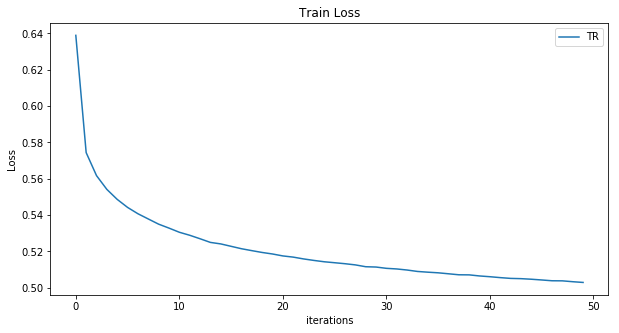

In [80]:
# Results
plt.figure(figsize=(10,5))
plt.title("Train Loss")
plt.plot(train_losses,label="TR")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

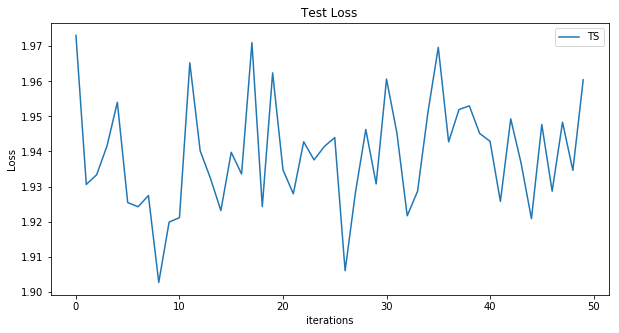

In [81]:
# Results
plt.figure(figsize=(10,5))
plt.title("Test Loss")
plt.plot(test_losses,label="TS")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [124]:
stft2cqt.eval()
xx = next(iter(dataloader))
ss = xx[0][0].reshape(1,1025)
cc = xx[1][0]
output = stft2cqt(ss)

/media/alex/Data/alex/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [127]:
output[0].shape

torch.Size([108])

In [126]:
ss.shape, cc.shape

(torch.Size([1, 1025]), torch.Size([108]))

In [128]:
output[0]-cc

tensor([-0.3264, -0.1713, -0.3305, -0.4712, -0.5507, -0.6807, -0.6476, -0.5825,
        -0.4488, -1.0285, -1.5620, -0.7155, -0.2959,  0.5470,  0.9537,  0.5396,
        -0.0198, -0.1128, -0.2993, -0.4801, -0.3946, -1.5413, -2.4431, -2.0730,
        -0.2938, -0.1902, -0.3856, -0.7801, -1.2727, -1.7023,  0.9222, -1.3332,
        -3.7709, -1.8980, -1.6796, -0.2380,  0.3142, -1.5018, -1.7655, -0.4585,
         0.2391, -0.1481, -0.1291,  0.8007,  0.8426, -0.5421, -4.1719, -2.9010,
        -0.5834, -0.8914, -0.2784, -0.0721,  0.2244, -0.8460, -1.5467, -0.8192,
        -0.7167, -0.0227, -0.8621, -1.3198, -0.8633,  0.0734, -0.8460, -0.6042,
        -0.6170, -0.6184, -0.1930, -0.4588, -0.6372, -0.3641, -0.2616, -0.7527,
        -0.5813, -3.2294, -2.7605, -1.4539, -1.0728, -1.2412, -2.1987, -1.3150,
        -1.1020, -1.0145, -0.3366, -0.8758, -1.4907, -1.0858, -0.6716, -1.0328,
        -0.6130,  0.0923, -0.7737, -1.7136, -1.9344, -0.6557, -0.6002, -1.4547,
        -1.2782, -1.1664, -0.7761, -1.33

In [129]:
output[0]

tensor([-0.7149, -0.5911, -0.6414, -0.6991, -0.6426, -0.6556, -0.6297, -0.5813,
        -0.4665, -0.4297, -0.1342, -0.3893, -0.6977,  0.0824,  0.5928,  0.2590,
        -0.3520, -0.4811, -0.6174, -0.7167, -0.5370, -0.4062, -0.4273, -0.7281,
        -0.7255, -0.6027,  0.3045, -0.0091, -0.7090, -0.6141,  0.0276,  0.4114,
         0.6265,  0.7888,  0.4057,  0.4817,  0.5480,  0.3121, -0.1098,  0.0120,
        -0.0157, -0.1254,  0.3685,  0.3439,  0.6288,  0.6302,  0.6517,  0.2688,
         0.0093,  0.0261, -0.3504, -0.3587, -0.5208, -0.4904, -0.2740, -0.1582,
        -0.5338, -0.4975, -0.7032, -0.2128,  0.1465, -0.0493, -0.7117, -0.7485,
        -0.7237, -0.7640, -0.4102, -0.2379, -0.8273, -0.8386, -0.8254, -0.8033,
         0.3912,  0.9974,  0.9935,  0.9349, -0.6939,  0.6675,  0.9756, -0.3242,
         0.2340,  0.8785,  0.3057,  0.4214,  0.2562, -0.2135,  0.4501,  0.1649,
        -0.1648, -0.1877, -0.1971,  0.0885,  0.5172,  0.5895,  0.3189,  0.0573,
        -0.4880, -0.3443, -0.4079, -0.11

In [130]:
cc

tensor([-3.8848e-01, -4.1975e-01, -3.1084e-01, -2.2789e-01, -9.1855e-02,
         2.5091e-02,  1.7965e-02,  1.2622e-03, -1.7665e-02,  5.9876e-01,
         1.4278e+00,  3.2618e-01, -4.0180e-01, -4.6454e-01, -3.6086e-01,
        -2.8060e-01, -3.3218e-01, -3.6834e-01, -3.1805e-01, -2.3660e-01,
        -1.4238e-01,  1.1350e+00,  2.0158e+00,  1.3450e+00, -4.3168e-01,
        -4.1242e-01,  6.9015e-01,  7.7096e-01,  5.6370e-01,  1.0882e+00,
        -8.9459e-01,  1.7446e+00,  4.3974e+00,  2.6868e+00,  2.0853e+00,
         7.1969e-01,  2.3380e-01,  1.8139e+00,  1.6557e+00,  4.7052e-01,
        -2.5472e-01,  2.2698e-02,  4.9761e-01, -4.5681e-01, -2.1381e-01,
         1.1722e+00,  4.8236e+00,  3.1698e+00,  5.9273e-01,  9.1747e-01,
        -7.2016e-02, -2.8661e-01, -7.4517e-01,  3.5555e-01,  1.2726e+00,
         6.6108e-01,  1.8287e-01, -4.7479e-01,  1.5895e-01,  1.1069e+00,
         1.0098e+00, -1.2271e-01,  1.3430e-01, -1.4421e-01, -1.0667e-01,
        -1.4556e-01, -2.1721e-01,  2.2091e-01, -1.9

In [138]:
np.std(C_stand)

0.9999999999999986

In [ ]:
# Train
train_losses = []
test_losses = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    errs = []
    test_errs = []
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        stft2cqt.zero_grad()
        # Format batch
        stft = data[0].view(-1,1,1025).to(device)
        cqt = data[1].view(-1,1,108).to(device)
        # Forward pass
        output = cqt2stft_conv(cqt)
        # Calculate loss
        err = mseLoss(stft, output)
        # Calculate gradients for D in backward pass
        err.backward()
        # Update D
        optimizer_stft2cqt.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch, num_epochs, i, len(dataloader), err.item()))
            
        # Save Losses for plotting later
        errs.append(err.item())
        
    with torch.no_grad():
        for j, test in enumerate(testloader, 0):
            stft_test = test[0].view(-1,1,1025).to(device)
            cqt_test = test[1].view(-1,1,108).to(device)
            output_test = cqt2stft_conv(cqt_test)
            err_test = mseLoss(stft_test, output_test)
            test_errs.append(err_test.item())

    train_losses.append(np.mean(errs))
    test_losses.append(np.mean(test_errs))
    print("Mean train error: {} \nMean test error: {} \n".format(np.mean(errs), np.mean(test_errs)))

Starting Training Loop...


/media/alex/Data/alex/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0/50][0/969]	Loss: 0.4787
[0/50][50/969]	Loss: 283.3751
[0/50][100/969]	Loss: 0.4778
[0/50][150/969]	Loss: 0.5060
[0/50][200/969]	Loss: 0.4736
[0/50][250/969]	Loss: 0.4723
[0/50][300/969]	Loss: 0.4664
[0/50][350/969]	Loss: 0.4776
[0/50][400/969]	Loss: 0.4379
[0/50][450/969]	Loss: 0.4445
[0/50][500/969]	Loss: 0.4409
[0/50][550/969]	Loss: 0.4329
[0/50][600/969]	Loss: 0.5340
[0/50][650/969]	Loss: 0.4870
[0/50][700/969]	Loss: 0.5495
[0/50][750/969]	Loss: 0.4517
[0/50][800/969]	Loss: 0.4742
[0/50][850/969]	Loss: 0.5042
[0/50][900/969]	Loss: 0.4887
[0/50][950/969]	Loss: 0.5931
Mean train error: 1.326887958956591 
Mean test error: 4.518269734574884 

[1/50][0/969]	Loss: 0.4470
[1/50][50/969]	Loss: 0.4931
[1/50][100/969]	Loss: 0.4450
[1/50][150/969]	Loss: 0.6058
[1/50][200/969]	Loss: 0.5122
[1/50][250/969]	Loss: 0.4447
[1/50][300/969]	Loss: 0.4413
[1/50][350/969]	Loss: 0.4779
[1/50][400/969]	Loss: 0.4607
[1/50][450/969]	Loss: 0.5225
[1/50][500/969]	Loss: 0.5244
[1/50][550/969]	Loss: 0.4197
[1

In [204]:
test[0].shape

torch.Size([32, 1025])

In [162]:
zh=cqt.view(128,2,54)
zh.shape

torch.Size([128, 2, 54])

In [165]:
data[0].shape[0]

128

In [164]:
#     t = t.reshape(1, -1)
#     t = t.squeeze()
zh.reshape(128,-1).shape

torch.Size([128, 108])